# Calibration of the Rahmstorf (2007) SLR Model

## Load Environment

In [1]:
import Pkg
Pkg.activate(dirname(@__DIR__))
Pkg.instantiate()


  Activating project at `~/Teaching/BEE4850/website/slides`


In [73]:
using Distributions
using StatsBase
using CSV
using DataFrames
using Optim
using Turing
using Plots
using StatsPlots

## Load Data

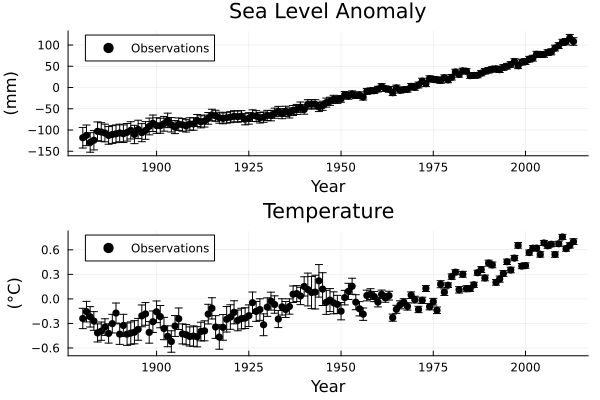

In [30]:
data_path = joinpath(dirname(@__DIR__), "data")
norm_yrs = 1951:1980

sl_dat = DataFrame(CSV.File(joinpath(data_path, "sealevel", "CSIRO_Recons_gmsl_yr_2015.csv")))

rename!(sl_dat, [:Year, :GMSLR, :SD]) # rename to make columns easier to work with
sl_dat[!, :Year] .-= 0.5 # shift year to line up with years instead of being half-year 
sl_dat[!, :GMSLR] .-= mean(filter(row -> row.Year ∈ norm_yrs, sl_dat)[!, :GMSLR]) # rescale to be relative to 1880-1900 mean for consistency with temperature anomaly

# load temperature data
temp_dat = DataFrame(CSV.File(joinpath(data_path, "climate", "HadCRUT.5.0.1.0.analysis.summary_series.global.annual.csv")))
rename!(temp_dat, [:Year, :Temp, :Lower, :Upper]) # rename to make columns easier to work with
filter!(row -> row.Year ∈ sl_dat[!, :Year], temp_dat) # reduce to the same years that we have SL data for
temp_normalize = mean(filter(row -> row.Year ∈ norm_yrs, temp_dat)[!, :Temp]) # get renormalization to rescale temperature to 1880-1900 mean
temp_dat[!, :Temp] .-= temp_normalize
temp_dat[!, :Lower] .-= temp_normalize
temp_dat[!, :Upper] .-=  temp_normalize

sl_plot = scatter(sl_dat[!, :Year], sl_dat[!, :GMSLR], yerr=sl_dat[!, :SD], color=:black, label="Observations", ylabel="(mm)", xlabel="Year", title="Sea Level Anomaly")

temp_plot = scatter(temp_dat[!, :Year], temp_dat[!, :Temp], yerr=(temp_dat[!, :Temp] - temp_dat[!, :Lower], temp_dat[!, :Upper] - temp_dat[!, :Temp]), color=:black, label="Observations", ylabel="(°C)", xlabel="Year", title="Temperature")

plot(sl_plot, temp_plot, layout=(2, 1))

## Model Specification

The Rahmstorf (2007) model is:

$$\frac{dH}{dt} = \alpha (T - T_0)$$

Discretizing:

$$H(t+1) = H(t) + \Delta t \alpha (T - T_0)$$

We'll set $\Delta t = 1 \text{yr}$. This means we need the following parameters:

- $\alpha$: SLR sensitivity to temperature anomalies $(mm/(yr \cdot ^\circ C))$,
- $T\_0$: Null temperature anomaly (no SLR at this temperature) $(^\circ C)$.
- $H_0 = H(0)$: Initial SL anomaly $(mm)$.

This is the **generative model**.

Simplest way to add residuals/measurement errors:

$$y_t \sim N(H(t), \sigma^2)$$

In [75]:
function rahmstorf_slr(params, temps; Δt=1)
    α, b, T₀, H₀ = params
    temp_diff = temps .- T₀
    ΔT = [0; diff(temps)]
    H = zeros(length(temps) + 1) # initialize storage
    H[1] = H₀
    for i = 2:length(H)
        H[i] = H[i-1] + α * Δt * temp_diff[i-1] + b * ΔT[i-1]
    end
    return H[2:end]
end

rahmstorf_slr (generic function with 2 methods)

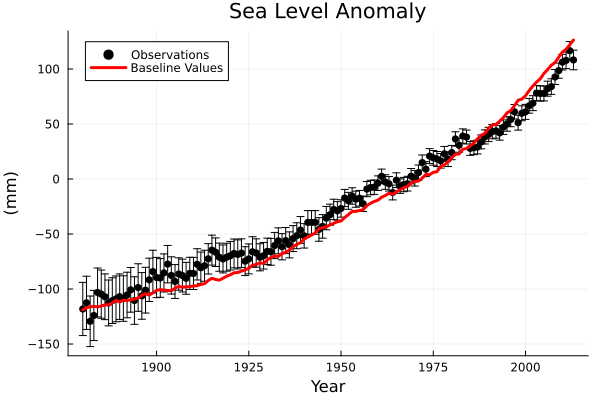

In [92]:
slr_ex = rahmstorf_slr((3.0, 8.0, -0.6, -120.0), temp_dat.Temp)
sl_plot = scatter(sl_dat[!, :Year], sl_dat[!, :GMSLR], yerr=sl_dat[!, :SD], color=:black, label="Observations", ylabel="(mm)", xlabel="Year", title="Sea Level Anomaly")
plot!(sl_plot, sl_dat[!, :Year], slr_ex, color=:red, linewidth=3, label="Baseline Values")

## Model Calibration 1: Gaussian iid Errors

In [78]:
# now the params include the standard deviation of the error model as well
function gaussian_iid_homosked(params, temp_dat, slr_dat, Δt=1.0)
    α, b, T₀, H₀, σ = params 
    slr_sim = rahmstorf_slr((α, b, T₀, H₀), temp_dat; Δt = Δt)
    ll = sum(logpdf.(Normal.(slr_sim, σ), slr_dat))
    return ll
end

gaussian_iid_homosked((4.6, 50.0, -0.5, -100.0, 5.0), temp_dat.Temp, sl_dat.GMSLR)

-8874.472323023905

In [94]:
low_bds = [0.0, -100.0, -5.0, -200.0, 0.0]
up_bds = [10.0, 100.0, 0.0, 0.0, 50.0]
p₀ = [3.4, 20.0, -0.5, -100.0, 10.0]

mle_optim = optimize(p -> -gaussian_iid_homosked(p, temp_dat.Temp, sl_dat.GMSLR), low_bds, up_bds, p₀)
p_mle = mle_optim.minimizer

5-element Vector{Float64}:
    1.9954491265469922
   -7.5317201796796605
   -0.8657256421723124
 -117.60853103602687
    5.8375424743684

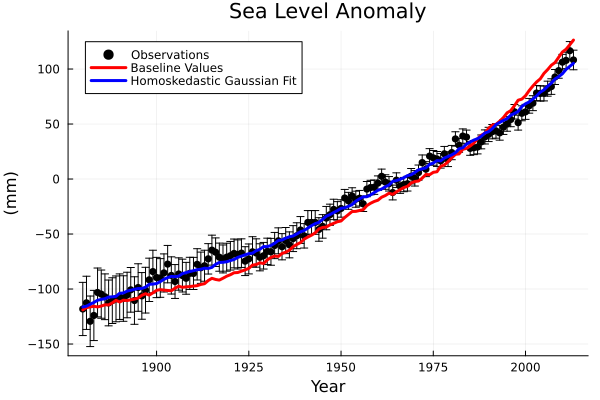

In [95]:
rahmstorf_homogauss_mle = rahmstorf_slr(p_mle, temp_dat.Temp)
plot!(sl_plot, sl_dat[!, :Year], rahmstorf_homogauss_mle, color=:blue, linewidth=3, label="Homoskedastic Gaussian Fit")

In [98]:
function gaussian_iid_heterosked(params, temp_dat, slr_dat, slr_err, Δt=1.0)
    α, b, T₀, H₀, σ = params 
    slr_sim = rahmstorf_slr((α, b, T₀, H₀), temp_dat; Δt = Δt)
    ll = sum(logpdf.(Normal.(slr_sim, sqrt.(σ^2 .+ slr_err.^2)), slr_dat))
    return ll
end


gaussian_iid_heterosked (generic function with 2 methods)

In [100]:
low_bds = [0.0, -100.0, -5.0, -200.0, 0.0]
up_bds = [10.0, 100.0, 0.0, 0.0, 50.0]
p₀ = [3.4, 20.0, -0.5, -100.0, 10.0]

mle_optim = optimize(p -> -gaussian_iid_heterosked(p, temp_dat.Temp, sl_dat.GMSLR, sl_dat.SD), low_bds, up_bds, p₀)
p_mle2 = mle_optim.minimizer
@show p_mle;
@show p_mle2;

p_mle = [1.9954491265469922, -7.5317201796796605, -0.8657256421723124, -117.60853103602687, 5.8375424743684]
p_mle2 = [1.9779826110074572, -2.946556480700747, -0.8443986931074989, -114.41206881367287, 5.093293910301493e-10]


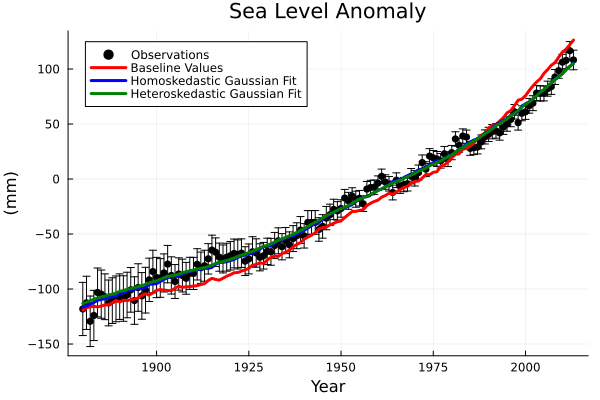

In [101]:
rahmstorf_heterogauss_mle = rahmstorf_slr(p_mle2, temp_dat.Temp)
plot!(sl_plot, sl_dat[!, :Year], rahmstorf_heterogauss_mle, color=:green, linewidth=3, label="Heteroskedastic Gaussian Fit")

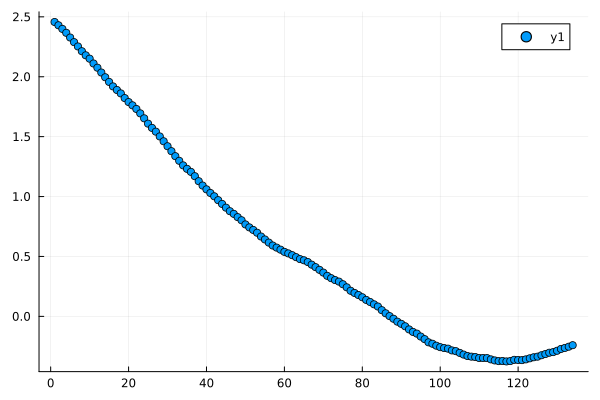

In [67]:
scatter(rahmstorf_heterogauss_mle - rahmstorf_homogauss_mle)

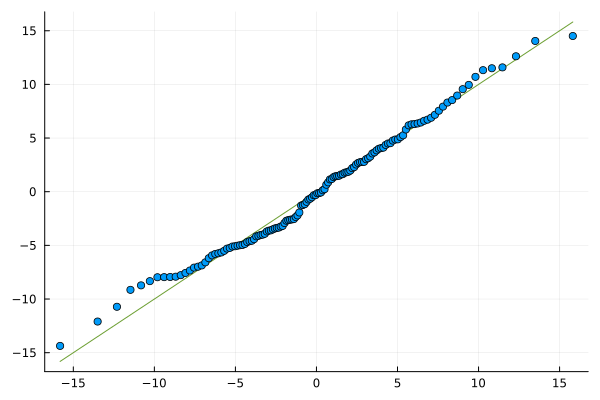

In [74]:
resids = sl_dat.GMSLR - rahmstorf_homogauss_mle
qqnorm(resids)
